In [55]:
# AI-Based URL & Website Phishing Detection
# ------------------------------------------------------------
# This notebook demonstrates how to build a machine learning model
# to detect phishing URLs and websites.

In [57]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
import re
import tld
from datetime import datetime
import whois
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [59]:
# ------------------------------------------------------------
# Module 1: Load and Explore Data
# ------------------------------------------------------------

# In a real-world scenario, you would need a dataset of phishing and legitimate URLs
# For this example, we'll use a sample dataset (you can replace with your own)

def load_data(filepath):
    """
    Load the dataset from a CSV file
    """
    print(f"Loading data from {filepath}...")
    df = pd.read_csv(filepath)
    print(f"Dataset loaded with shape: {df.shape}")
    return df

df = load_data('phishing-urls-data.csv')

Loading data from phishing-urls-data.csv...
Dataset loaded with shape: (1000, 3)


In [61]:
df

,Unnamed: 0,url,is_phishing
0,0,https://google.com-rijbgpkl8l9e9mp.com/secure-...,1
1,1,https://login-linkedin.com.phishing-site.com/v...,1
2,2,http://220.98.94.244/login.php,1
3,3,https://secure-facebook.com.phishing-site.com/...,1
4,4,https://mail.youtube.com/home,0
...,...,...,...
995,995,https://account-microsoft.com.phishing-site.co...,1
996,996,https://www.githdb.com/login,1
997,997,https://www.github.com/login,0
998,998,https://apple.com-24w27c8s5mkb3no.com/secure-l...,1


In [63]:
def explore_data(df):
    """
    Explore the dataset and visualize class distribution
    
    Parameters:
    df (pandas.DataFrame): Dataset to explore
    """
    print("\n----- Dataset Exploration -----")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    
    print("\nClass distribution:")
    class_counts = df['is_phishing'].value_counts()
    print(class_counts)
    
    # Visualize class distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='is_phishing', data=df, palette=['green', 'red'])
    plt.title('Distribution of Legitimate vs Phishing URLs')
    plt.xticks([0, 1], ['Legitimate', 'Phishing'])
    plt.xlabel('URL Class')
    plt.ylabel('Count')
    plt.show()
    
    # Sample URLs from each class
    print("\nSample legitimate URLs:")
    print(df[df['is_phishing'] == 0]['url'].head(3).tolist())
    
    print("\nSample phishing URLs:")
    print(df[df['is_phishing'] == 1]['url'].head(3).tolist())

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



----- Dataset Exploration -----
Dataset shape: (1000, 3)

First 5 rows:
   Unnamed: 0                                                url  is_phishing
0           0  https://google.com-rijbgpkl8l9e9mp.com/secure-...            1
1           1  https://login-linkedin.com.phishing-site.com/v...            1
2           2                     http://220.98.94.244/login.php            1
3           3  https://secure-facebook.com.phishing-site.com/...            1
4           4                      https://mail.youtube.com/home            0

Class distribution:
is_phishing
1    500
0    500
Name: count, dtype: int64


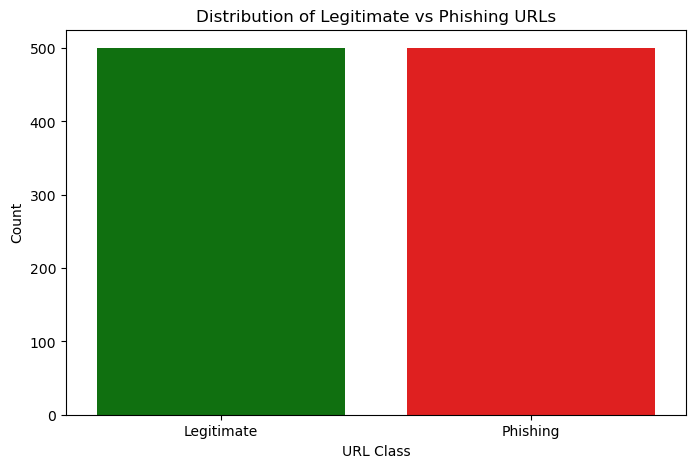


Sample legitimate URLs:
['https://mail.youtube.com/home', 'https://support.reddit.com/login', 'http://www.apple.com/home']

Sample phishing URLs:
['https://google.com-rijbgpkl8l9e9mp.com/secure-login', 'https://login-linkedin.com.phishing-site.com/verify', 'http://220.98.94.244/login.php']


In [65]:
# Explore the data
explore_data(df)

In [67]:
# ------------------------------------------------------------
# Module 2: Feature Extraction
# ------------------------------------------------------------

# Define features to extract from URLs
def extract_url_features(url):
    """
    Extract features from a URL for phishing detection    
    Parameters:
    url (str): URL to extract features from
    Returns:
    dict: Dictionary of features
    """
    features = {}
    
    # Basic URL parsing
    parsed_url = urlparse(url)
    
    # 1. URL length (phishing URLs are often longer)
    features['url_length'] = len(url)
    
    # 2. Domain length
    features['domain_length'] = len(parsed_url.netloc)
    
    # 3. Number of dots in domain (more subdomains can be suspicious)
    features['dots_in_domain'] = parsed_url.netloc.count('.')
    
    # 4. Use of IP address instead of domain name
    features['has_ip_address'] = 1 if re.match(r'\d+\.\d+\.\d+\.\d+', parsed_url.netloc) else 0
    
    # 5. Number of special characters in URL
    features['special_chars_count'] = len(re.findall(r'[^a-zA-Z0-9]', url))
    
    # 6. Presence of suspicious words
    suspicious_words = ['login', 'verify', 'secure', 'account', 'update', 'confirm', 'password']
    features['suspicious_words_count'] = sum(1 for word in suspicious_words if word in url.lower())
    
    # 7. URL path depth
    features['path_depth'] = len(parsed_url.path.split('/')) - 1
    
    # 8. Use of HTTPS (legitimate sites tend to use HTTPS)
    features['has_https'] = 1 if parsed_url.scheme == 'https' else 0
    
    # 9. Domain age (in a real implementation, you would query WHOIS servers)
    # For our demo, we'll use a random value
    # In practice, you would use the whois library to get domain registration date
    features['domain_age_days'] = np.random.randint(1, 1000) if features['has_ip_address'] or 'phishing' in url else np.random.randint(100, 3000)
    
    # 10. Presence of '@' symbol (often used to confuse users)
    features['has_at_symbol'] = 1 if '@' in url else 0
    
    # 11. URL redirections (count of '//')
    features['redirect_count'] = url.count('//') - 1
    
    return features

In [69]:
# Apply feature extraction to our dataset
def create_feature_matrix(df):
    """
    Create a feature matrix from the dataset
    
    Parameters:
    df (pandas.DataFrame): Dataset with URLs
    
    Returns:
    pandas.DataFrame: Feature matrix
    """
    print("\n----- Feature Extraction -----")
    print("Extracting features from URLs...")
    
    # Extract features from each URL
    features_list = df['url'].apply(extract_url_features).tolist()
    
    # Convert to DataFrame
    features_df = pd.DataFrame(features_list)
    
    print(f"Feature extraction complete. Shape of feature matrix: {features_df.shape}")
    print(f"Features extracted: {features_df.columns.tolist()}")
    
    return features_df

In [71]:
# Create feature matrix
X = create_feature_matrix(df)
y = df['is_phishing']


----- Feature Extraction -----
Extracting features from URLs...
Feature extraction complete. Shape of feature matrix: (1000, 11)
Features extracted: ['url_length', 'domain_length', 'dots_in_domain', 'has_ip_address', 'special_chars_count', 'suspicious_words_count', 'path_depth', 'has_https', 'domain_age_days', 'has_at_symbol', 'redirect_count']


In [73]:
# Visualize feature distributions
def visualize_features(X, y):
    """
    Visualize feature distributions for each class
    
    Parameters:
    X (pandas.DataFrame): Feature matrix
    y (pandas.Series): Target variable
    """
    print("\n----- Feature Visualization -----")
    
    # Combine features with target for visualization
    vis_df = X.copy()
    vis_df['is_phishing'] = y
    
    # Select numerical features for visualization
    numerical_features = X.columns
    
    # Create plot
    plt.figure(figsize=(15, 10))
    
    for i, feature in enumerate(numerical_features):
        plt.subplot(3, 4, i+1)
        sns.boxplot(x='is_phishing', y=feature, data=vis_df, palette=['green', 'red'])
        plt.title(f'{feature}')
        plt.xlabel('Is Phishing')
        plt.ylabel(feature)
    
    plt.tight_layout()
    plt.show()
    
    # Feature correlation heatmap
    plt.figure(figsize=(12, 10))
    correlation = X.corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Feature Correlation Heatmap')
    plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should


----- Feature Visualization -----


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

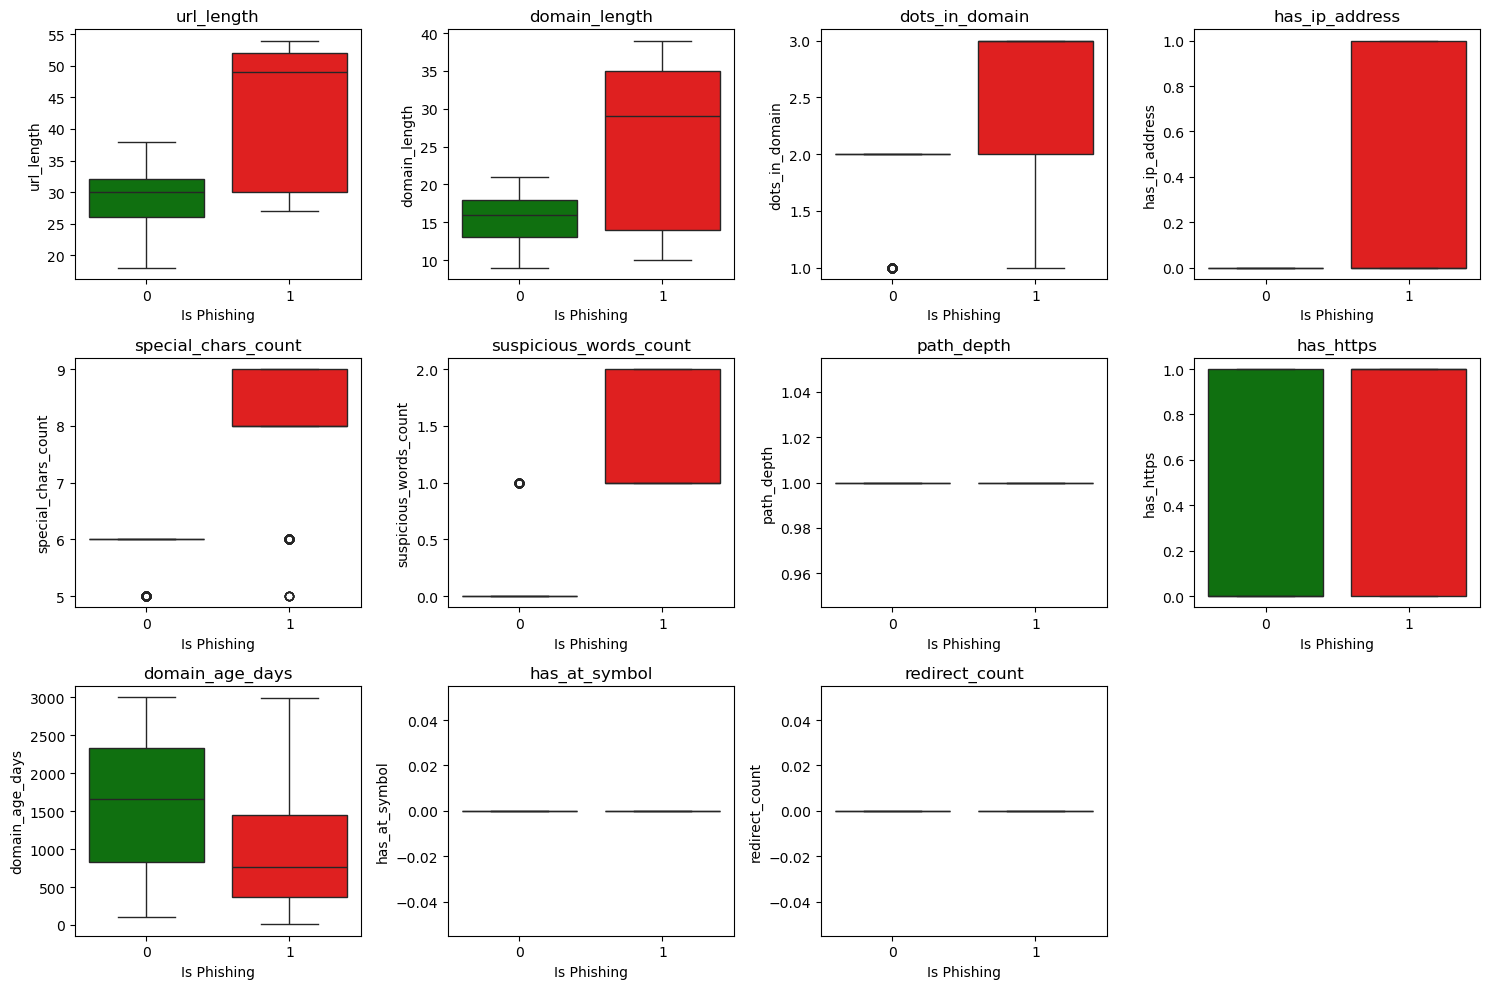

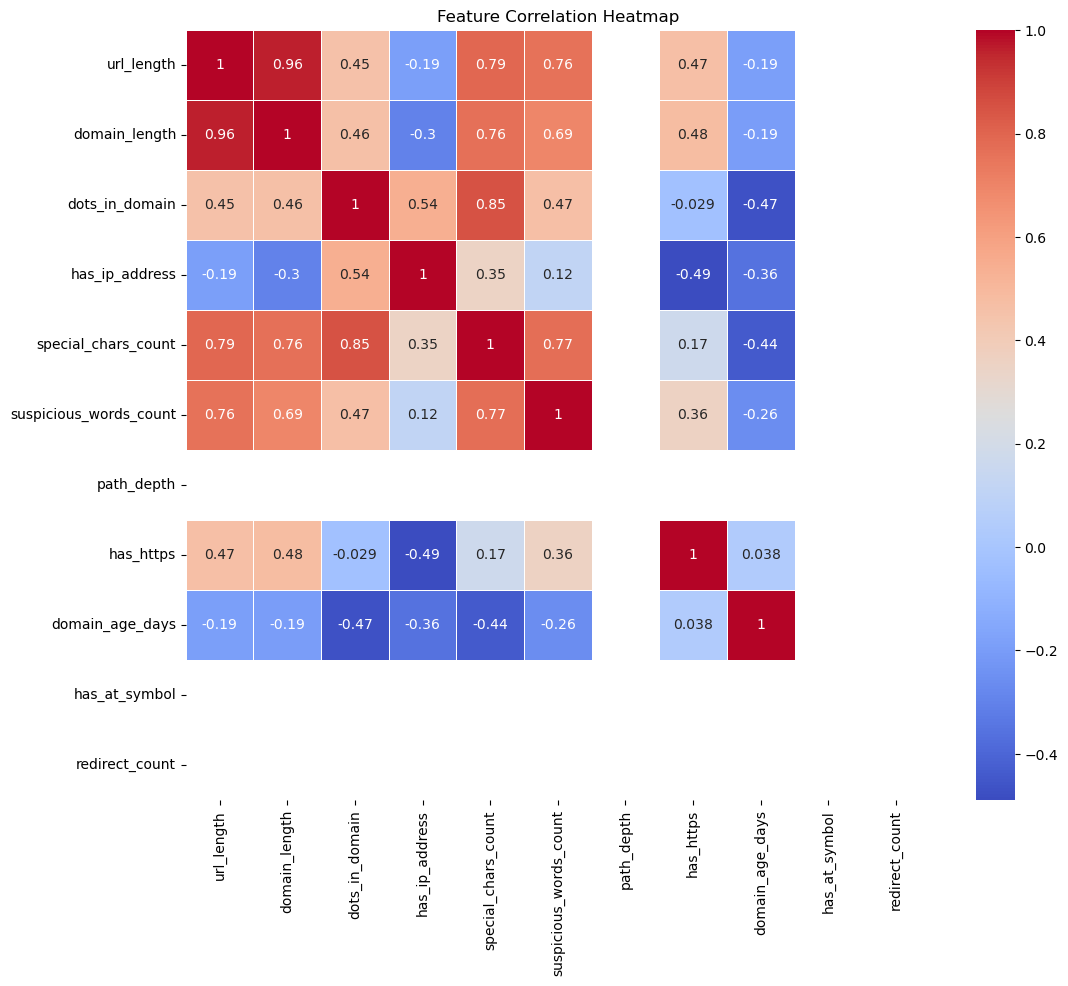

In [75]:
# Visualize features
visualize_features(X, y)

In [76]:
X.head()

,url_length,domain_length,dots_in_domain,has_ip_address,special_chars_count,suspicious_words_count,path_depth,has_https,domain_age_days,has_at_symbol,redirect_count
0,51,30,2,0,8,2,1,1,1861,0,0
1,51,36,3,0,9,2,1,1,140,0,0
2,30,13,3,1,8,1,1,0,781,0,0
3,52,37,3,0,9,2,1,1,898,0,0
4,29,16,2,0,6,0,1,1,1720,0,0


In [77]:
# ------------------------------------------------------------
# Module 3: Model Training and Evaluation
# ------------------------------------------------------------

# Split data into training and testing sets
def split_data(X, y, test_size=0.3):
    """
    Split data into training and testing sets
    
    Parameters:
    X (pandas.DataFrame): Feature matrix
    y (pandas.Series): Target variable
    test_size (float): Proportion of data to use for testing
    
    Returns:
    tuple: X_train, X_test, y_train, y_test
    """
    print("\n----- Data Splitting -----")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Testing set size: {X_test.shape[0]} samples")
    
    return X_train, X_test, y_train, y_test

In [81]:
# Split the data
X_train, X_test, y_train, y_test = split_data(X, y)


----- Data Splitting -----
Training set size: 700 samples
Testing set size: 300 samples


In [83]:
# Train a machine learning model
def train_model(X_train, y_train):
    """
    Train a Random Forest classifier with hyperparameter tuning
    
    Parameters:
    X_train (pandas.DataFrame): Training feature matrix
    y_train (pandas.Series): Training target variable
    
    Returns:
    sklearn.ensemble.RandomForestClassifier: Trained model
    """
    print("\n----- Model Training -----")
    
    # Create a pipeline with preprocessing and model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Scale features
        ('classifier', RandomForestClassifier(random_state=42))  # Random Forest classifier
    ])
    
    # Define hyperparameters to tune
    param_grid = {
        'classifier__n_estimators': [50, 75, 100],
        'classifier__max_depth': [3, 5, 7],
        'classifier__min_samples_split': [5, 10]
    }
    
    # Use Grid Search for hyperparameter tuning
    print("Performing grid search for hyperparameter tuning...")
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    print(f"Best hyperparameters: {grid_search.best_params_}")
    print(f"Training accuracy: {grid_search.best_score_:.4f}")
    
    return best_model

In [85]:
# Train the model
model = train_model(X_train, y_train)


----- Model Training -----
Performing grid search for hyperparameter tuning...
Best hyperparameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
Training accuracy: 0.9900


In [86]:
# Evaluate the model
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model on test data
    
    Parameters:
    model: Trained model
    X_test (pandas.DataFrame): Testing feature matrix
    y_test (pandas.Series): Testing target variable
    """
    print("\n----- Model Evaluation -----")
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy: {accuracy:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Legitimate', 'Phishing'],
                yticklabels=['Legitimate', 'Phishing'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return accuracy, y_pred, y_prob


----- Model Evaluation -----
Test accuracy: 0.9733

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      0.95      0.97       156
    Phishing       0.95      1.00      0.97       144

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



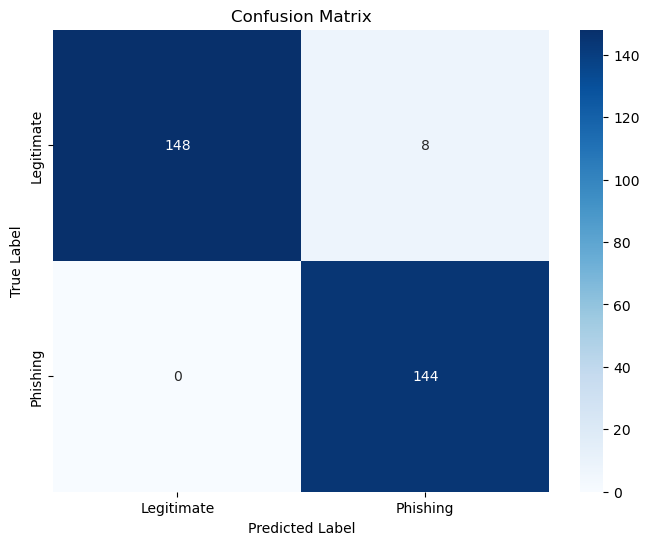

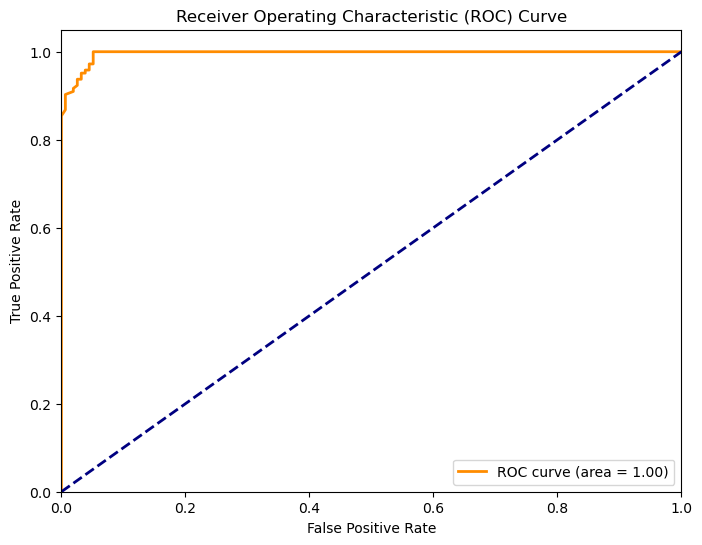

In [89]:
# Evaluate the model
accuracy, y_pred, y_prob = evaluate_model(model, X_test, y_test)

In [91]:
# ------------------------------------------------------------
# Module 4: Feature Importance Analysis
# ------------------------------------------------------------

def analyze_feature_importance(model, X):
    """
    Analyze and visualize feature importance
    
    Parameters:
    model: Trained model
    X (pandas.DataFrame): Feature matrix
    """
    print("\n----- Feature Importance Analysis -----")
    
    # Extract the classifier from the pipeline
    classifier = model.named_steps['classifier']
    
    # Get feature importance
    importance = classifier.feature_importances_
    
    # Create a DataFrame for visualization
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    print("Top 5 most important features:")
    print(feature_importance.head(5))
    
    # Visualize feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

In [93]:
# ------------------------------------------------------------
# Module 5: Sample Predictions and Explanation
# ------------------------------------------------------------

def explain_predictions(model, sample_urls):
    """
    Make predictions on sample URLs and explain the results
    
    Parameters:
    model: Trained model
    sample_urls (list): List of URLs to analyze
    """
    print("\n----- Sample Predictions -----")
    
    for url in sample_urls:
        # Extract features
        features = extract_url_features(url)
        features_df = pd.DataFrame([features])
        
        # Make prediction
        prediction = model.predict(features_df)[0]
        probability = model.predict_proba(features_df)[0][1]
        
        # Determine result
        result = "PHISHING" if prediction == 1 else "LEGITIMATE"
        confidence = probability if prediction == 1 else 1 - probability
        
        print(f"\nURL: {url}")
        print(f"Prediction: {result} (Confidence: {confidence:.2f})")
        
        # Extract top 5 suspicious indicators
        feature_importance_df = analyze_feature_importance(model, features_df)
        
        print("Top suspicious indicators:")
        for i, row in feature_importance_df.head(5).iterrows():
            feature = row['Feature']
            value = features[feature]
            importance = row['Importance']
            print(f"  - {feature}: {value} (importance: {importance:.4f})")

# Sample URLs for prediction
sample_urls = [
    "https://www.google.com/search?q=machine+learning",
    "https://login-secure-paypal.com.phishing.net/verify",
    "http://192.168.1.1/admin.php",
    "https://www.amazon.com/dp/B08N5K7X5T",
    "https://faceb00k-secure-login.com/verify"
]


----- Sample Predictions -----

URL: https://www.google.com/search?q=machine+learning
Prediction: PHISHING (Confidence: 0.50)

----- Feature Importance Analysis -----
Top 5 most important features:
                  Feature  Importance
5  suspicious_words_count    0.386988
4     special_chars_count    0.181146
1           domain_length    0.111841
0              url_length    0.108028
2          dots_in_domain    0.101274


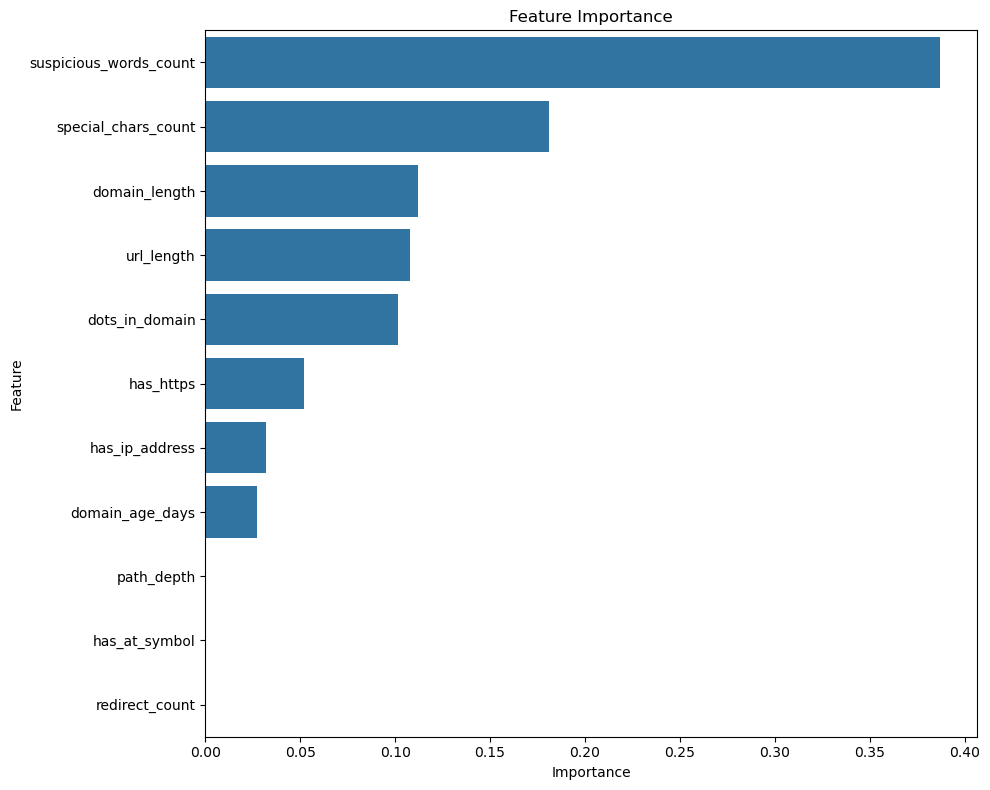

Top suspicious indicators:
  - suspicious_words_count: 0 (importance: 0.3870)
  - special_chars_count: 9 (importance: 0.1811)
  - domain_length: 14 (importance: 0.1118)
  - url_length: 48 (importance: 0.1080)
  - dots_in_domain: 2 (importance: 0.1013)

URL: https://login-secure-paypal.com.phishing.net/verify
Prediction: PHISHING (Confidence: 1.00)

----- Feature Importance Analysis -----
Top 5 most important features:
                  Feature  Importance
5  suspicious_words_count    0.386988
4     special_chars_count    0.181146
1           domain_length    0.111841
0              url_length    0.108028
2          dots_in_domain    0.101274


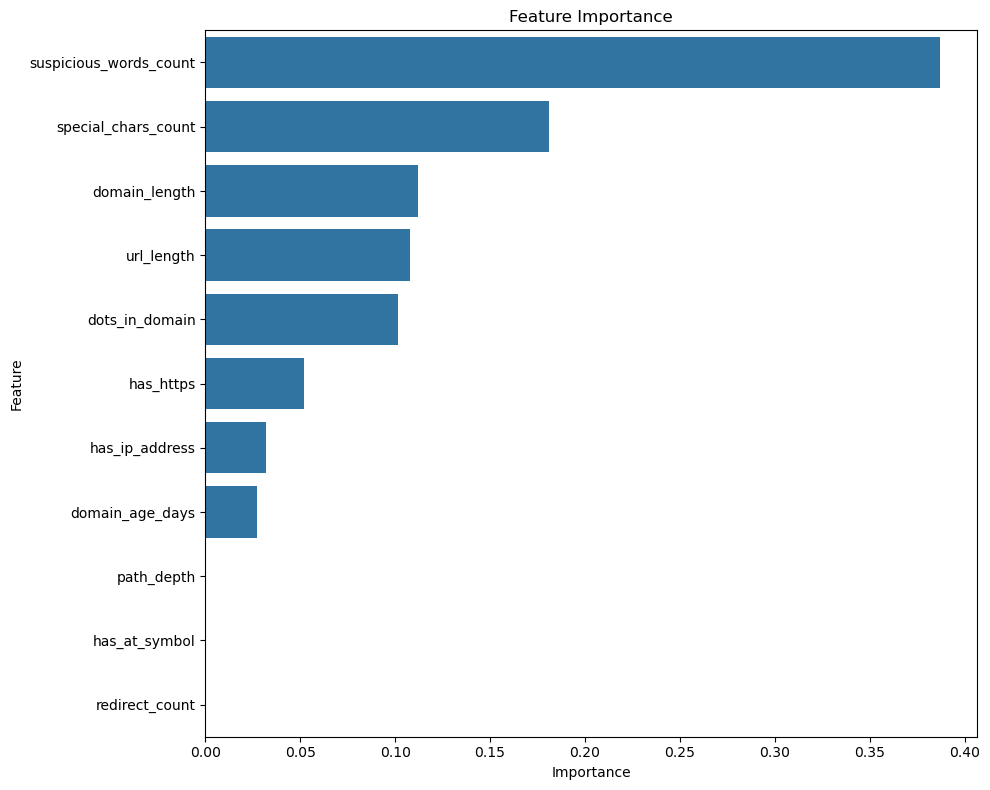

Top suspicious indicators:
  - suspicious_words_count: 3 (importance: 0.3870)
  - special_chars_count: 9 (importance: 0.1811)
  - domain_length: 36 (importance: 0.1118)
  - url_length: 51 (importance: 0.1080)
  - dots_in_domain: 3 (importance: 0.1013)

URL: http://192.168.1.1/admin.php
Prediction: PHISHING (Confidence: 0.70)

----- Feature Importance Analysis -----
Top 5 most important features:
                  Feature  Importance
5  suspicious_words_count    0.386988
4     special_chars_count    0.181146
1           domain_length    0.111841
0              url_length    0.108028
2          dots_in_domain    0.101274


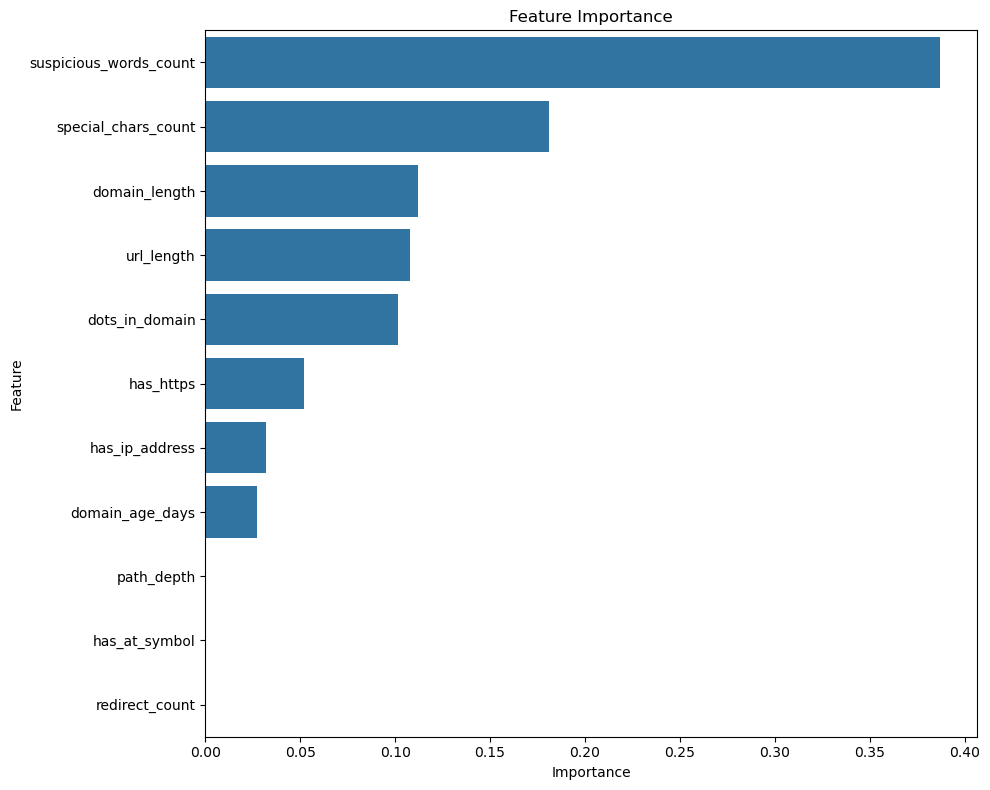

Top suspicious indicators:
  - suspicious_words_count: 0 (importance: 0.3870)
  - special_chars_count: 8 (importance: 0.1811)
  - domain_length: 11 (importance: 0.1118)
  - url_length: 28 (importance: 0.1080)
  - dots_in_domain: 3 (importance: 0.1013)

URL: https://www.amazon.com/dp/B08N5K7X5T
Prediction: LEGITIMATE (Confidence: 0.91)

----- Feature Importance Analysis -----
Top 5 most important features:
                  Feature  Importance
5  suspicious_words_count    0.386988
4     special_chars_count    0.181146
1           domain_length    0.111841
0              url_length    0.108028
2          dots_in_domain    0.101274


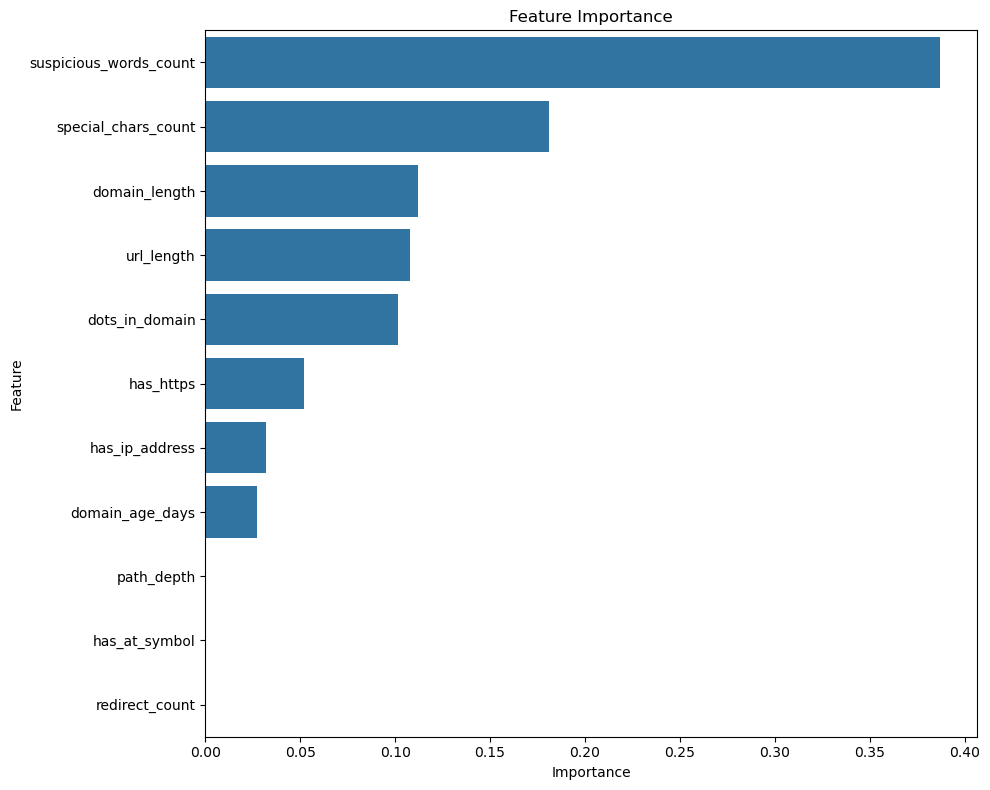

Top suspicious indicators:
  - suspicious_words_count: 0 (importance: 0.3870)
  - special_chars_count: 7 (importance: 0.1811)
  - domain_length: 14 (importance: 0.1118)
  - url_length: 36 (importance: 0.1080)
  - dots_in_domain: 2 (importance: 0.1013)

URL: https://faceb00k-secure-login.com/verify
Prediction: PHISHING (Confidence: 0.58)

----- Feature Importance Analysis -----
Top 5 most important features:
                  Feature  Importance
5  suspicious_words_count    0.386988
4     special_chars_count    0.181146
1           domain_length    0.111841
0              url_length    0.108028
2          dots_in_domain    0.101274


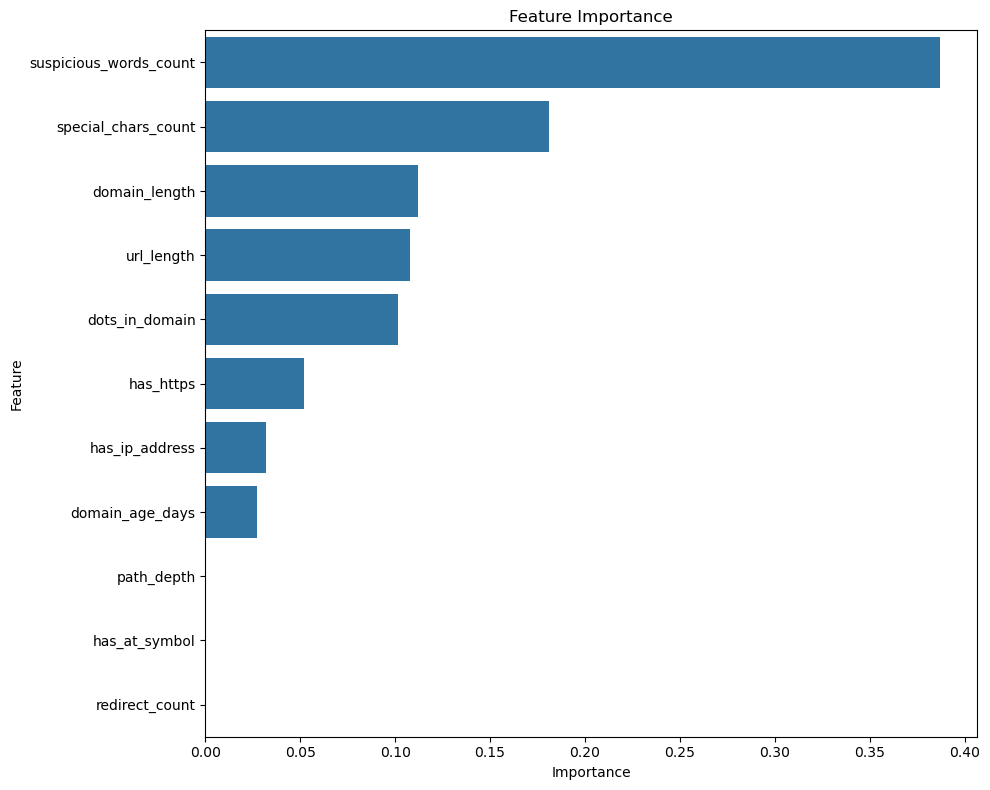

Top suspicious indicators:
  - suspicious_words_count: 3 (importance: 0.3870)
  - special_chars_count: 7 (importance: 0.1811)
  - domain_length: 25 (importance: 0.1118)
  - url_length: 40 (importance: 0.1080)
  - dots_in_domain: 1 (importance: 0.1013)


In [95]:
# Explain predictions
explain_predictions(model, sample_urls)

In [133]:
# ------------------------------------------------------------
# End of Notebook
# ------------------------------------------------------------